In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/91845/Desktop/projects/product_embeddings/config'
import random
import datetime
import math
import zipfile
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras import backend  as K
from keras.layers import (
    Input, 
    Embedding, 
    Dot, 
    Dense, 
    Multiply, 
    Concatenate
)
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import initializers
from keras import activations
from tensorflow.keras.utils import plot_model

In [2]:
BASE_DIR_PATH = 'C:/Users/91845/Desktop/projects/product_embeddings/data/instacart-market-basket-analysis'
DATASET_FILEPATH = 'C:/Users/91845/Desktop/projects/product_embeddings/data/instacart-market-basket-analysis/prepared_dataset'

In [3]:
# load the products data to memory
products_df = pd.read_csv(f'{BASE_DIR_PATH}/products.csv/products.csv')
# map each product to aisle id and department id
total_products = len(products_df)
aisle_map: dict = dict()
department_map: dict = dict()
for ix, row in tqdm(products_df.iterrows(), total=total_products):
    department_map[row['product_id']] = row['department_id']
    aisle_map[row['product_id']] = row['aisle_id']

max_products = products_df.product_id.nunique() + 1
max_aisles = products_df.aisle_id.nunique() + 1
max_departments = products_df.department_id.nunique() + 1

max_products, max_aisles, max_departments

100%|██████████| 49688/49688 [02:32<00:00, 325.69it/s]  


(49689, 135, 22)

In [4]:
# Modelling
input_shape = 1
output_shape = 1
embedding_shape_item = 64
embedding_shape_dept_aisle = 16

# define inputs to the model
first_input_pid = Input(shape=(input_shape, ), name='first_pid')
first_input_dept_id = Input(shape=(input_shape, ), name='first_dept')
first_input_aisle_id = Input(shape=(input_shape, ), name='first_aisle')
second_input_pid = Input(shape=(input_shape, ), name='second_pid')
second_input_dept_id = Input(shape=(input_shape, ), name='second_dept')
second_input_aisle_id = Input(shape=(input_shape, ), name='second_aisle')

embedding_layer_pid = Embedding(
     input_dim=max_products, 
     output_dim=embedding_shape_item,
     name='product_embedding',
     embeddings_initializer='uniform',
     embeddings_regularizer=None, 
     activity_regularizer=None, 
     mask_zero=None, 
     input_length=input_shape
)

embedding_layer_dept = Embedding(
    input_dim=max_departments, 
    output_dim=embedding_shape_dept_aisle, 
    name='department_embedding',
    embeddings_initializer='uniform', 
    embeddings_regularizer=None, 
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=None, 
    input_length=input_shape
)

embedding_layer_aisles = Embedding(
    input_dim=max_aisles, 
    output_dim=embedding_shape_dept_aisle, 
    name='aisle_embedding',
    embeddings_initializer='uniform', 
    embeddings_regularizer=None, 
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=None, 
    input_length=input_shape
)

# embedding layer for both inputs
first_input_encoded_pid = embedding_layer_pid(first_input_pid)
first_input_encoded_dept_id = embedding_layer_dept(first_input_dept_id)
first_input_encoded_aisle_id = embedding_layer_aisles(first_input_aisle_id)

second_input_encoded_pid = embedding_layer_pid(second_input_pid)
second_input_encoded_dept_id = embedding_layer_dept(second_input_dept_id)
second_input_encoded_aisle_id = embedding_layer_aisles(second_input_aisle_id)

first_input_encoded_concatenated = Concatenate(name='first_input_concatenation')([
    first_input_encoded_pid, 
    first_input_encoded_dept_id, 
    first_input_encoded_aisle_id
])
second_input_encoded_concatenated = Concatenate(name='second_input_concatentation')([
    second_input_encoded_pid, 
    second_input_encoded_dept_id, 
    second_input_encoded_aisle_id
])

# multiplication layer
# element wise dot product
dot_product = Multiply(name='multiplication')([
    first_input_encoded_concatenated, 
    second_input_encoded_concatenated
])

# adding more dense layers
dense_layer1 = Dense(64, input_shape=(96, ), activation='elu', kernel_initializer=initializers.he_normal())(dot_product)
dense_layer2 = Dense(32, input_shape=(64, ), activation='elu', kernel_initializer=initializers.he_normal())(dense_layer1)

# output layer 
y = Dense(1, activation='sigmoid')(dense_layer2)

final_model = Model(inputs=[
    first_input_pid, 
    first_input_dept_id, 
    first_input_aisle_id, 
    second_input_pid, 
    second_input_dept_id, 
    second_input_aisle_id
], outputs=y)

final_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [5]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 first_pid (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 first_dept (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 first_aisle (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 second_pid (InputLayer)     [(None, 1)]                  0         []                            
                                                                                              

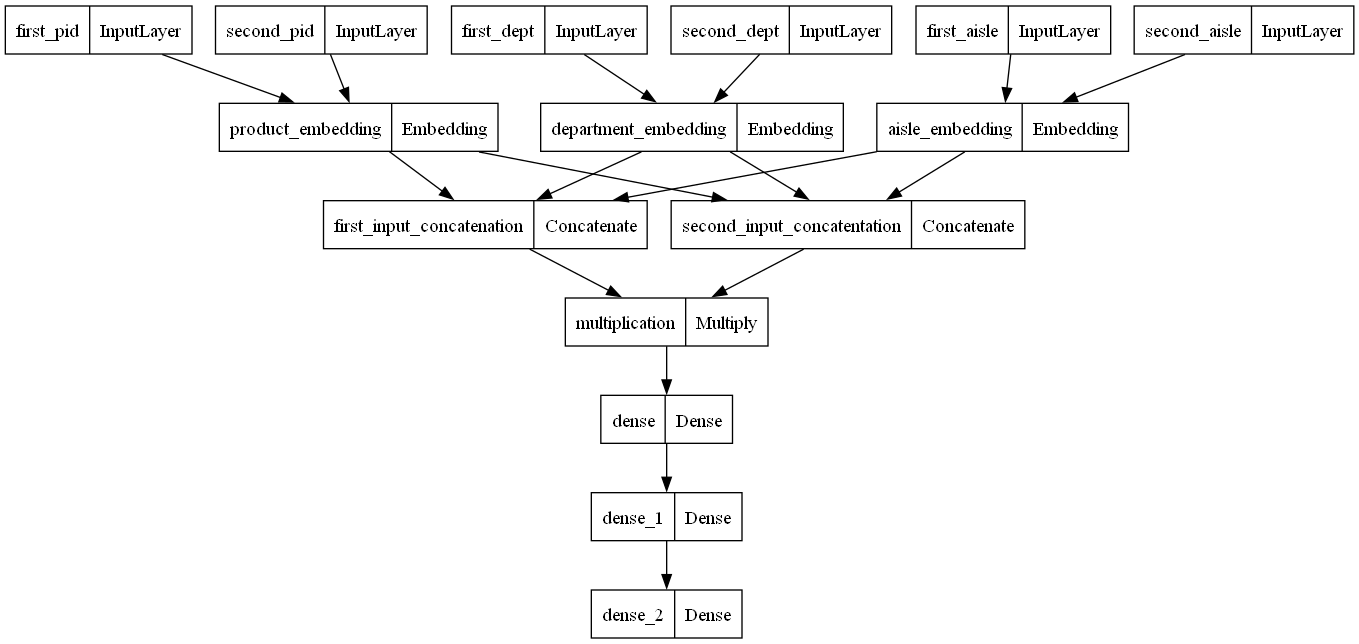

In [6]:
plot_model(final_model)

In [7]:
all_files = glob.glob(os.path.join(DATASET_FILEPATH, '*.csv'))
def generate_batches_val(files, batch_size, val_split): 
    counter = 0

    while True: 
        fname = files[counter]

        counter = (counter + 1)%len(files)
        batch = pd.read_csv(fname)

        batch['dept_id1'] = batch['pid1'].apply(lambda p: department_map[p])
        batch['aisle_id1'] = batch['pid1'].apply(lambda p: aisle_map[p])

        batch['dept_id2'] = batch['pid2'].apply(lambda p: department_map[p])
        batch['aisle_id2'] = batch['pid2'].apply(lambda p: aisle_map[p])

        for local_index in range(0, batch.shape[0], batch_size):
            till = int(batch_size*(1-val_split))
            from_idx = local_index
            to_idx = local_index + batch_size - till

            input_local_pid1 = batch.iloc[from_idx:to_idx]['pid1']
            input_local_dept_id1 = batch.iloc[from_idx:to_idx]['dept_id1']
            input_local_aisle_id1 = batch.iloc[from_idx:to_idx]['aisle_id1']
            
            input_local_pid2 = batch.iloc[from_idx:to_idx]['pid2']
            input_local_dept_id2 = batch.iloc[from_idx:to_idx]['dept_id2']
            input_local_aisle_id2 = batch.iloc[from_idx:to_idx]['aisle_id2']

            output_local = batch.iloc[from_idx:to_idx]['label']
            yield [
                np.array(input_local_pid1),
                np.array(input_local_dept_id1), 
                np.array(input_local_aisle_id1), 
                np.array(input_local_pid2), 
                np.array(input_local_dept_id2),
                np.array(input_local_aisle_id2)
            ], np.array(output_local).reshape((-1, 1))


def generate_batches_train(files, batch_size, val_split): 
    counter = 0

    while True: 
        fname = files[counter]

        counter = (counter + 1)%len(files)
        batch = pd.read_csv(fname)

        batch['dept_id1'] = batch['pid1'].apply(lambda p: department_map[p])
        batch['aisle_id1'] = batch['pid1'].apply(lambda p: aisle_map[p])

        batch['dept_id2'] = batch['pid2'].apply(lambda p: department_map[p])
        batch['aisle_id2'] = batch['pid2'].apply(lambda p: aisle_map[p])

        for local_index in range(0, batch.shape[0], batch_size):
            till = int(batch_size*(1-val_split))
            from_idx = local_index + batch_size - till
            to_idx = local_index + batch_size

            input_local_pid1 = batch.iloc[from_idx:to_idx]['pid1']
            input_local_dept_id1 = batch.iloc[from_idx:to_idx]['dept_id1']
            input_local_aisle_id1 = batch.iloc[from_idx:to_idx]['aisle_id1']
            
            input_local_pid2 = batch.iloc[from_idx:to_idx]['pid2']
            input_local_dept_id2 = batch.iloc[from_idx:to_idx]['dept_id2']
            input_local_aisle_id2 = batch.iloc[from_idx:to_idx]['aisle_id2']

            output_local = batch.iloc[from_idx:to_idx]['label']

            yield [
                np.array(input_local_pid1),
                np.array(input_local_dept_id1), 
                np.array(input_local_aisle_id1), 
                np.array(input_local_pid2), 
                np.array(input_local_dept_id2),
                np.array(input_local_aisle_id2)
            ], np.array(output_local).reshape((-1, 1))

In [8]:
BATCH_SIZE: int = 8000
VAL_SPLIT: float = 0.15

train_files = all_files

train_generator = generate_batches_train(files=train_files, batch_size=BATCH_SIZE, val_split=VAL_SPLIT)
val_generator = generate_batches_val(files=train_files, batch_size=BATCH_SIZE, val_split=VAL_SPLIT)

In [9]:
checkpoint_filepath = 'C:/Users/91845/Desktop/projects/product_embeddings/models/best_model_iter_2.h5'

In [10]:
EPOCHS_CNT: int = 100

model_checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    patience=10, 
    start_from_epoch=15
)

In [11]:
hist = final_model.fit(
    steps_per_epoch=len(train_files)*10, 
    x=train_generator, 
    verbose=1, 
    max_queue_size=32, 
    validation_data=val_generator,
    validation_steps=len(train_files)*10, 
    epochs=EPOCHS_CNT, 
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100

670/670 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.5964

c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.63885, saving model to C:/Users/91845/Desktop/projects/product_embeddings/models\best_model_iter_2.h5
670/670 [==============================] - 193s 288ms/step - loss: 0.6517 - accuracy: 0.5964 - val_loss: 0.6189 - val_accuracy: 0.6389
Epoch 2/100


c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


670/670 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.6483
Epoch 2: val_accuracy improved from 0.63885 to 0.65778, saving model to C:/Users/91845/Desktop/projects/product_embeddings/models\best_model_iter_2.h5
670/670 [==============================] - 154s 229ms/step - loss: 0.6064 - accuracy: 0.6483 - val_loss: 0.5943 - val_accuracy: 0.6578
Epoch 3/100
670/670 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6573
Epoch 3: val_accuracy improved from 0.65778 to 0.65839, saving model to C:/Users/91845/Desktop/projects/product_embeddings/models\best_model_iter_2.h5
670/670 [==============================] - 234s 349ms/step - loss: 0.5931 - accuracy: 0.6573 - val_loss: 0.5958 - val_accuracy: 0.6584
Epoch 4/100


c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


670/670 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.6332
Epoch 4: val_accuracy did not improve from 0.65839
670/670 [==============================] - 155s 232ms/step - loss: 0.6177 - accuracy: 0.6332 - val_loss: 0.6077 - val_accuracy: 0.6423
Epoch 5/100
670/670 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.6469
Epoch 5: val_accuracy did not improve from 0.65839
670/670 [==============================] - 115s 172ms/step - loss: 0.6016 - accuracy: 0.6469 - val_loss: 0.5953 - val_accuracy: 0.6527
Epoch 6/100
670/670 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.6494
Epoch 6: val_accuracy did not improve from 0.65839
670/670 [==============================] - 215s 322ms/step - loss: 0.5981 - accuracy: 0.6494 - val_loss: 0.6001 - val_accuracy: 0.6499
Epoch 7/100
670/670 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6423
Epoch 7: val_accuracy did not improve from 0.65839
670/670 [======

c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


670/670 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.6471
Epoch 9: val_accuracy did not improve from 0.66031
670/670 [==============================] - 215s 321ms/step - loss: 0.6006 - accuracy: 0.6471 - val_loss: 0.6008 - val_accuracy: 0.6478
Epoch 10/100
670/670 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.6478
Epoch 10: val_accuracy did not improve from 0.66031
670/670 [==============================] - 139s 207ms/step - loss: 0.5998 - accuracy: 0.6478 - val_loss: 0.5934 - val_accuracy: 0.6534
Epoch 11/100
670/670 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.6572
Epoch 11: val_accuracy improved from 0.66031 to 0.66123, saving model to C:/Users/91845/Desktop/projects/product_embeddings/models\best_model_iter_2.h5
670/670 [==============================] - 142s 211ms/step - loss: 0.5879 - accuracy: 0.6572 - val_loss: 0.5825 - val_accuracy: 0.6612
Epoch 12/100


c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


670/670 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6446
Epoch 12: val_accuracy did not improve from 0.66123
670/670 [==============================] - 218s 326ms/step - loss: 0.6036 - accuracy: 0.6446 - val_loss: 0.6007 - val_accuracy: 0.6467
Epoch 13/100
670/670 [==============================] - ETA: 0s - loss: 0.5979 - accuracy: 0.6496
Epoch 13: val_accuracy did not improve from 0.66123
670/670 [==============================] - 144s 214ms/step - loss: 0.5979 - accuracy: 0.6496 - val_loss: 0.5919 - val_accuracy: 0.6547
Epoch 14/100
670/670 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.6589
Epoch 14: val_accuracy improved from 0.66123 to 0.66233, saving model to C:/Users/91845/Desktop/projects/product_embeddings/models\best_model_iter_2.h5
670/670 [==============================] - 144s 215ms/step - loss: 0.5864 - accuracy: 0.6589 - val_loss: 0.5813 - val_accuracy: 0.6623
Epoch 15/100


c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


670/670 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.6445
Epoch 15: val_accuracy did not improve from 0.66233
670/670 [==============================] - 216s 323ms/step - loss: 0.6046 - accuracy: 0.6445 - val_loss: 0.5992 - val_accuracy: 0.6492
Epoch 16/100
670/670 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.6526
Epoch 16: val_accuracy did not improve from 0.66233
670/670 [==============================] - 142s 212ms/step - loss: 0.5947 - accuracy: 0.6526 - val_loss: 0.5890 - val_accuracy: 0.6575
Epoch 17/100
670/670 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.6616
Epoch 17: val_accuracy improved from 0.66233 to 0.66563, saving model to C:/Users/91845/Desktop/projects/product_embeddings/models\best_model_iter_2.h5
670/670 [==============================] - 178s 265ms/step - loss: 0.5836 - accuracy: 0.6616 - val_loss: 0.5786 - val_accuracy: 0.6656
Epoch 18/100


c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


670/670 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.6432
Epoch 18: val_accuracy did not improve from 0.66563
670/670 [==============================] - 153s 228ms/step - loss: 0.6060 - accuracy: 0.6432 - val_loss: 0.5986 - val_accuracy: 0.6491
Epoch 19/100
670/670 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.6542
Epoch 19: val_accuracy did not improve from 0.66563
670/670 [==============================] - 152s 227ms/step - loss: 0.5927 - accuracy: 0.6542 - val_loss: 0.5860 - val_accuracy: 0.6602
Epoch 20/100
670/670 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.6596
Epoch 20: val_accuracy did not improve from 0.66563
670/670 [==============================] - 228s 340ms/step - loss: 0.5853 - accuracy: 0.6596 - val_loss: 0.5894 - val_accuracy: 0.6604
Epoch 21/100
670/670 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.6430
Epoch 21: val_accuracy did not improve from 0.66563
670/670 